Optimise CNOT in quantum system

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os, shutil

#QuTiP
import qutip.logging_utils as logging
logger = logging.get_logger()
#Local
import qsoconfig, qso, qsorun


Configuration

In [2]:
# Create the configuration object
# This holds the parameters for the pulse optimisation and any
# general parameters
cfg = qsoconfig.gen_optim_config(parse_cl_args=False)
# fid_type options pure_Choi_local|pure_Choi_global|unit_global
cfg.fid_type = 'pure_choi_local'
# stats_type options: standard|local
cfg.stats_type = 'local'
# If true then processing stats will be collected
cfg.gen_stats = True
# If True then stats for each pulse optimisation will be reported
cfg.report_stats = False
# Print messaging level 0-3
cfg.verbosity = 1
# qutip internal logging level
cfg.log_level = logging.WARN
# If True then the physics parameters are included in the output
cfg.report_phys_params = False
# Folder where any output files will be saved
cfg.output_dir = "output/optim_CNOT/default"
# Used as part of output file names
cfg.output_base_name = 'qso_CNOT'
# Keep the pulse optimisation results, so we can plot amplitudes later
cfg.keep_optim_result = True

# Pulse generator type.
# Options: 
# For descriptions see qutip.control.pulsegen.create_pulse_gen
# Only the random types make sense with multiple repetitions
cfg.p_type = 'RND'

# These will be used as amplitude bounds for the PulseGenerator and the Optimizer
cfg.amp_lbound = -np.Inf
cfg.amp_ubound = np.Inf
# Number of repetions for each pulse optimisation
cfg.num_reps = 10
# Number of cpus to utilise
cfg.num_cpus = 4

dir_ok, cfg.output_dir, msg = cfg.check_create_output_dir(cfg.output_dir)
if not dir_ok:
    raise RuntimeError(msg)
print("Output files will be saved in:\n{}".format(cfg.output_dir))

# Create the Optimizer object and its children
# (Dynamics, FidelityComputer, TerminationConditions...)
optim = qsoconfig.gen_optim_objects(cfg)


No parameter file. Using defaults in code.
Output files will be saved in:
output/optim_CNOT/default
evo_time=10.0
num_tslots=12


In [3]:
# Configure the quantum system
dyn = optim.dynamics
# Configure the quantum system
# Physical parameters of the model
# Any number of qubits >= 3 can choosen. However larger numbers take a lot of processing
dyn.num_qubits = 3
# interact options: Ising|Heisenberg| or combinations of xyz
dyn.interact = 'Ising'
# topology options: chain|star|full|ring
dyn.topology = 'chain'
# ctrls_type options: combinations of xyz
dyn.ctrls_type = 'XY'
# Interaction strengths (see qsoconfig.py for details)
dyn.coup_const = 1.0
# By CNOT gate is always on qubits 1&2
# These attribs can be used to permute the couplings to effectively move the gate qubits
# (see qsoconfig.py for details)
dyn.hspace_order = []
dyn.auto_hspace = False
dyn.hspace_01_sep = 0
dyn.hspace_0_idx = 0


In [4]:
# Pulse parameters
# Number of timeslots for the pulse discretisation
dyn.num_tslots = 12
# Time allowed for the gate to evolve
dyn.evo_time = 10.0

# Pulse optimisation termination conditions
# The optimisation algorithm will stop when any of these conditions are met
tc = optim.termination_conditions
# Target for the infidelity (1 - gate fidelity)
tc.fid_err_targ = 1e-3
# Sum of the gradients wrt optimisation parameters (timeslot amplitudes)
tc.min_gradient_norm = 1e-30
# Number of iterations of the algorithm
tc.max_iter = 200
# Computation time (in seconds)
tc.max_wall_time = 60.0
# Relative change in fid_err between iterations
# (see qutip / scipy documentation for details)
tc.accuracy_factor = 1e5

# Fidelity computer
fid_comp = dyn.fid_computer

# This is the maximum precsion that sub-system fidelities are 'measured'
# see choi_closed_fidcomp.my_round for details
# Zero implies full machine precision
fid_comp.numer_acc = 0.0

# Pulse generator
p_gen = optim.pulse_generator
# by default initial amplitudes will be between -1 and 1
# This can be changed by setting the bounds or scaling
p_gen.lbound = cfg.amp_lbound
p_gen.ubound = cfg.amp_ubound
p_gen.scaling = 1.0

# Create the targets and Hamiltonians

qsoconfig.config_dynamics(dyn)


Configuring drift...
... for 3 qubits
using Ising interactions
Drift dims [[2, 2, 2], [2, 2, 2]]
using Ising interactions
Normalising drift with factor 1.0


Run the pulse optimisation repetions

In [5]:
combres = qsorun.run_qso_sims_mp(optim)

Will run 4 reps on process 1 and 2 on another 3 processes
Will use 1 threads per process
Will start reps_idx 0 for 4 reps
Will start reps_idx 1 for 2 reps
Will start reps_idx 2 for 2 reps
Will start reps_idx 3 for 2 reps
All MP reps complete
Combined results saved to:
output/optim_CNOT/default/comb_qso_CNOT-pure_choi_local-chain-Ising-XY-CNOT-nq3.j0.txt
Full results
fid_err_targ	fid_err_primary	fid_err_secondary	num_iter	run_time	termination
1.0000e-03	0.000896073646	0.000552610035	46	0:00:01.774165	Goal achieved
1.0000e-03	0.00089670317	0.000545019754	35	0:00:01.522351	Goal achieved
1.0000e-03	0.000950663912	0.000494753624	69	0:00:02.782466	Goal achieved
1.0000e-03	0.00095733241	0.000614117756	60	0:00:02.440239	Goal achieved
1.0000e-03	0.000961131528	0.00058739103	45	0:00:01.839356	Goal achieved
1.0000e-03	0.0009665954	0.000531070127	43	0:00:01.650493	Goal achieved
1.0000e-03	0.000970008336	0.000504521834	53	0:00:02.110590	Goal achieved
1.0000e-03	0.000980766133	0.000613643842	56	0:00

Visualisation

(array([ 3.,  3.,  2.,  2.]),
 array([ 35. ,  44.5,  54. ,  63.5,  73. ]),
 <a list of 4 Patch objects>)

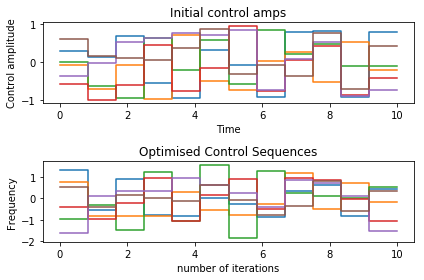

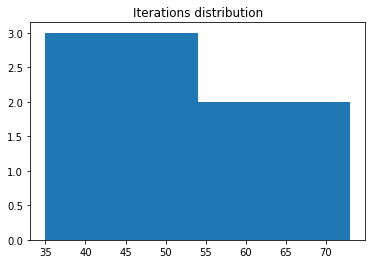

In [6]:
# Plot the initial and final pulse for the best fidelity result
best_result = combres.results[0].optim_result

u0 = best_result.initial_amps
uf = best_result.final_amps
time = best_result.time

fig1 = plt.figure()
ax1 = fig1.add_subplot(2, 1, 1)
ax1.set_title("Initial control amps")
ax1.set_xlabel("Time")
ax1.set_ylabel("Control amplitude")
for j in range(dyn.num_ctrls):
    ax1.step(time, np.hstack((u0[:, j], u0[-1, j])), where='post')

ax2 = fig1.add_subplot(2, 1, 2)
ax2.set_title("Optimised Control Sequences")
ax2.set_xlabel("Time")
ax2.set_ylabel("Control amplitude")
for j in range(dyn.num_ctrls):
    ax2.step(time, np.hstack((uf[:, j], uf[-1, j])), where='post')

fig1.tight_layout()

# Plot histogram of iterations for each repetition
num_iter = [r.num_iter for r in combres.results]
nbins = int(max(4, cfg.num_reps / 4))
fig2 = plt.figure()
ax3 = fig2.add_subplot(1, 1, 1)
ax3.set_title("Iterations distribution")
ax2.set_xlabel("number of iterations")
ax2.set_ylabel("Frequency")
ax3.hist(num_iter, bins=nbins)



Numerical accuracy threshold search

Note that this search typically requires many repeated pulse optimisations. Meaning it will take a lot of cpu time.


In [13]:
# Reset some paramters to be suitable for demonstrating the automatic search for 
# the numerical accuracy threshold
# Note these parameters are chosen to mimimise processing time,
# and are not ideal for creating a statistically valid result

cfg.output_dir = "output/optim_CNOT/nal"

# 50 reps would be much better
cfg.num_reps = 10
# 50 scenarios would be much better
cfg.max_mp_scens = 20

# Take an easy target fidelity
tc.fid_err_targ = 1e-1

# These next parameters are only used in the automatic search for the numerical
# accuracy threshold
fid_comp.st_numer_acc = 0.01
fid_comp.end_numer_acc = 0.05
# These proportions are used to determine the boundaries for the search
# They are proportions of the number number of successful repeats 
# for the scenario.
fid_comp.success_prop_uthresh = 0.90
fid_comp.success_prop_lthresh = 0.1

dir_ok, cfg.output_dir, msg = cfg.check_create_output_dir(cfg.output_dir)
if not dir_ok:
    raise RuntimeError(msg)

# Clear any existing result collation file, otherwise this will be loaded
# and the search will continue from where it left off
for f in os.listdir(cfg.output_dir):
    fp = os.path.join(cfg.output_dir, f)
    if os.path.isfile(fp):
        os.unlink(fp)
        
qsorun.run_qso_sims_numer_acc_limit(optim)

# As there is no parameter file, we need to save some data for the interpolater
interp_data = [dyn.num_qubits, fid_comp.st_numer_acc, fid_comp.end_numer_acc]
interp_fpath = os.path.join(cfg.output_dir, "interp.dat")
np.savetxt(interp_fpath, interp_data, fmt='%.5e')


Running 1 concurrent scenarios with 4 cpus per scenario
Looking for collation file matching output/optim_CNOT/nal/nal_collate*.txt
Start with fixed scenarios [0.01, 0.05]:
All initial scenarios [0.01, 0.05]:
Run scenario numer_acc=0.01 with 4 cpus
Will run 4 reps on process 1 and 2 on another 3 processes
Will use 1 threads per process
Will start reps_idx 0 for 4 reps
Will start reps_idx 1 for 2 reps
Will start reps_idx 2 for 2 reps
Will start reps_idx 3 for 2 reps
Run scenario numer_acc=0.05 with 4 cpus
Will run 4 reps on process 1 and 2 on another 3 processes
Will use 1 threads per process
Will start reps_idx 0 for 4 reps
Will start reps_idx 1 for 2 reps
Will start reps_idx 2 for 2 reps
Will start reps_idx 3 for 2 reps
All na now: [0.01, 0.05]
succ props: [0.9, 0.1]
Upper threshold last met at idx -1
Lower threshold first met at idx 2
Upper threshold not met, reducing min numer_acc
Lower threshold not met, increasing max numer_acc
forcing na vals: [0.005, 0.1]
active na vals (for gaps

All na now: [0.005, 0.01, 0.014999999999999999, 0.02, 0.022499999999999999, 0.025000000000000001, 0.029999999999999999, 0.032500000000000001, 0.035000000000000003, 0.040000000000000001, 0.05, 0.0625, 0.074999999999999997, 0.1]
succ props: [1.0, 0.9, 0.9, 0.7, 0.8, 0.2, 0.1, 0.3, 0.2, 0.0, 0.1, 0.1, 0.0, 0.0]
Upper threshold last met at idx 0
Lower threshold first met at idx 9
forcing na vals: []
active na vals (for gaps): [0.005, 0.01, 0.014999999999999999, 0.02, 0.022499999999999999, 0.025000000000000001, 0.029999999999999999, 0.032500000000000001, 0.035000000000000003, 0.040000000000000001]
All chosen na vals: [0.017500000000000002]
Run scenario numer_acc=0.0175 with 4 cpus
Will run 4 reps on process 1 and 2 on another 3 processes
Will use 1 threads per process
Will start reps_idx 0 for 4 reps
Will start reps_idx 1 for 2 reps
Will start reps_idx 2 for 2 reps
Will start reps_idx 3 for 2 reps
All na now: [0.005, 0.01, 0.014999999999999999, 0.017500000000000002, 0.02, 0.0224999999999999